In [56]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Patch

# 0. Carga del archivo creado con anterioridad y sobre el que se va a ejecutar gran parte del análisis

In [57]:
df_F1 = pd.read_csv("./data/F1.csv", low_memory=False)

In [58]:
df_F1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16632 entries, 0 to 16631
Data columns (total 37 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   resultId         16632 non-null  int64  
 1   raceId           16632 non-null  int64  
 2   driverId         16632 non-null  int64  
 3   constructorId    16632 non-null  int64  
 4   number           16632 non-null  int64  
 5   grid             16632 non-null  int64  
 6   position         16632 non-null  object 
 7   positionText     16632 non-null  object 
 8   positionOrder    16632 non-null  int64  
 9   points           16632 non-null  float64
 10  laps             16632 non-null  int64  
 11  time             16632 non-null  object 
 12  milliseconds     16632 non-null  object 
 13  fastestLap       16632 non-null  object 
 14  rank             16632 non-null  object 
 15  fastestLapTime   16632 non-null  object 
 16  fastestLapSpeed  16632 non-null  object 
 17  statusId    

### Eliminación filas fuera del estudio del EDA.   
Como se ha comentado en la memoria, solo se disponian de datos de adelantamientos desde 1984 hasta 2024, por lo que se van a eliminar las filas correspondientes a los años fuera de ese periodo.   
También se va a eliminar el año 2024 ya que no esta acabada la temporada y carece de sentido su análisis en este momento.

In [59]:
filtro_since_1984 = df_F1[df_F1.year < 1984].index
filtro_2024 = df_F1[df_F1.year == 2024].index
df_F1 = df_F1.drop(filtro_since_1984)
df_F1 = df_F1.drop(filtro_2024)

In [60]:
pd.set_option("display.max_columns", None)
df_F1.head(3)

,resultId,raceId,driverId,constructorId,number,grid,position,positionText,positionOrder,points,laps,time,milliseconds,fastestLap,rank,fastestLapTime,fastestLapSpeed,statusId,year,round,circuitId,name_x,date,url,circuitRef,name_y,location,country,lat,lng,alt,dob,nationality_x,driverName,status,name,nationality_y
0,1,18,1,1,22,1,1,1,1,10.0,58,1:34:50.616,5690616,39,2,1:27.452,218.300,1,2008,1,1,Australian Grand Prix,2008-03-16,http://en.wikipedia.org/wiki/2008_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,1985-01-07,British,Lewis Hamilton,Finished,McLaren,British
1,2,18,2,2,3,5,2,2,2,8.0,58,+5.478,5696094,41,3,1:27.739,217.586,1,2008,1,1,Australian Grand Prix,2008-03-16,http://en.wikipedia.org/wiki/2008_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,1977-05-10,German,Nick Heidfeld,Finished,BMW Sauber,German
2,3,18,3,3,7,7,3,3,3,6.0,58,+8.163,5698779,41,5,1:28.090,216.719,1,2008,1,1,Australian Grand Prix,2008-03-16,http://en.wikipedia.org/wiki/2008_Australian_G...,albert_park,Albert Park Grand Prix Circuit,Melbourne,Australia,-37.8497,144.968,10,1985-06-27,German,Nico Rosberg,Finished,Williams,British


# 1 - Analisis por temporada de cuantas veces ha ganado un mismo piloto un GP

## 1.1 - Valor absoluto

In [61]:
filtro_primera_posicion = df_F1.positionOrder == 1
df_pos_1 = df_F1[filtro_primera_posicion]
df_pos_1_abs = df_pos_1.groupby(["year","driverName"], as_index=False)["position"].value_counts()
df_pos_1_abs = df_pos_1_abs.groupby(["year"], as_index=False)["count"].max().sort_values(by="count",ascending = True)
df_pos_1_abs.sort_values(by="year").head(3)

,year,count
0,1984,7
1,1985,5
2,1986,5


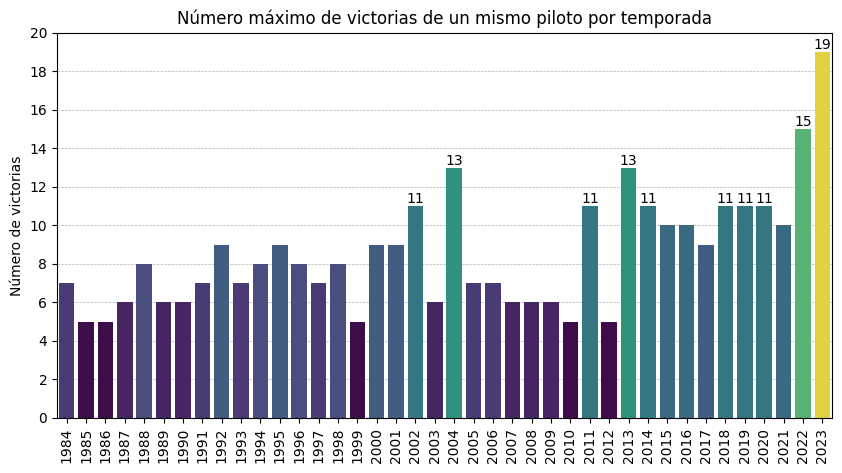

In [62]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,5))

axes = sns.barplot(df_pos_1_abs, x="year", y="count",hue="count", legend=False, palette="viridis",ax=axs)
axs.tick_params(axis="x", labelrotation=90)
axs.set_ylabel("Número de victorias")
axs.set_ylim(0,20)
plt.yticks(range (0,22,2))
plt.grid(axis="y", linestyle = "dashed", linewidth = 0.5)
axs.set_axisbelow(True)
axs.set_title("Número máximo de victorias de un mismo piloto por temporada")
axs.set_xlabel("");

for p in axs.patches:
    height = int(p.get_height())
    if height > 10:  # Solo mostrar si el valor es mayor a 10
        axs.annotate(height, (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.savefig("./img/1_Mismo_driver/Mismo_1.png")   

## 1.2 - Valor relativo --> se tiene en cuenta el numero de GPs que se corrieron esa temporada

In [63]:
df_rel = df_F1.groupby(["year","raceId"], as_index=False)["raceId"].unique()
df_pos_1_rel = df_rel.groupby(["year"], as_index=False).count()
df_pos_1_rel.head(3)

,year,raceId
0,1984,16
1,1985,16
2,1986,16


In [64]:
df_pos_1_rel["ratio"] = round(df_pos_1_abs["count"]/df_pos_1_rel["raceId"]*100,1)
df_pos_1_rel.head(3)

,year,raceId,ratio
0,1984,16,43.8
1,1985,16,31.2
2,1986,16,31.2


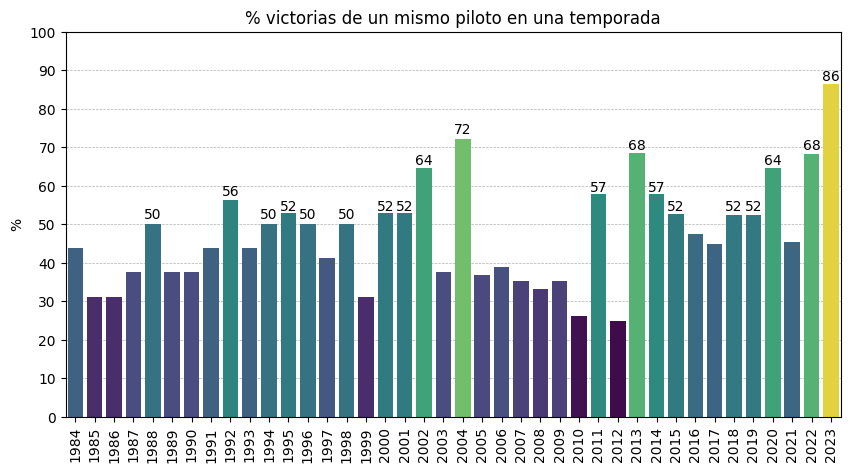

In [65]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(10,5))

axes = sns.barplot(df_pos_1_rel, x="year", y="ratio",hue="ratio", legend=False, palette="viridis",ax=axs)
axs.tick_params(axis="x", labelrotation=90)
axs.set_ylabel("%")
axs.set_ylim(0,20)
plt.yticks(range (0,110,10))
plt.grid(axis="y", linestyle = "dashed", linewidth = 0.5)
axs.set_axisbelow(True)
axs.set_title("% victorias de un mismo piloto en una temporada")
axs.set_xlabel("");

for p in axs.patches:
    height = int(p.get_height())
    if height >= 47.4:  # Solo mostrar si el valor es mayor a 10
        axs.annotate(height, (p.get_x() + p.get_width() / 2., height), 
                     ha='center', va='center', xytext=(0, 7), textcoords='offset points')
        
plt.savefig("./img/1_Mismo_driver/Mismo_2.png")   

### Cálculo % de cuantas carreras gana un mismo piloto en una temporada

In [66]:
df_pos_1_rel.ratio.sum()
df_pos_1_rel.shape[0]
media = df_pos_1_rel.ratio.sum()/df_pos_1_rel.shape[0]
media

47.447500000000005

## 1.3 - Calculo de pilotos que aun habiendo ganado mas carreras, no fueron campones del mundo

In [67]:
filtro_primera_posicion = df_F1['positionOrder'] == 1
df_pos_1 = df_F1[filtro_primera_posicion]
df_victorias = df_pos_1.groupby(['year', 'driverName']).size().reset_index(name='count')
df_max_victorias = df_victorias.loc[df_victorias.groupby('year')['count'].idxmax()]
df_max_victorias.reset_index(drop=True, inplace=True)
df_max_victorias.head(3)

,year,driverName,count
0,1984,Alain Prost,7
1,1985,Alain Prost,5
2,1986,Nigel Mansell,5


In [68]:
df_puntos = df_F1.groupby(["year","driverName"], as_index=False)["points"].sum().sort_values(by="year",ascending = False)
df_max_puntos = df_puntos.loc[df_puntos.groupby("year")["points"].idxmax()]
df_max_puntos.head(3)


,year,driverName,points
23,1984,Niki Lauda,72.0
35,1985,Alain Prost,76.0
71,1986,Alain Prost,74.0


In [69]:
df_victorias_vs_campeon = pd.merge(df_max_victorias, df_max_puntos, on="year", how="left")
df_victorias_vs_campeon.rename(columns={"driverName_x":"Driver_max_wins","driverName_y":"Driver_season_winner"}, inplace=True)
df_victorias_vs_campeon.head(3)

,year,Driver_max_wins,count,Driver_season_winner,points
0,1984,Alain Prost,7,Niki Lauda,72.0
1,1985,Alain Prost,5,Alain Prost,76.0
2,1986,Nigel Mansell,5,Alain Prost,74.0


In [70]:
victorias_winner = df_victorias_vs_campeon["Driver_max_wins"] == df_victorias_vs_campeon["Driver_season_winner"]
victorias_winner.value_counts()

True     32
False     8
Name: count, dtype: int64

In [71]:
df_victorias_vs_campeon[victorias_winner==False]

,year,Driver_max_wins,count,Driver_season_winner,points
0,1984,Alain Prost,7,Niki Lauda,72.0
2,1986,Nigel Mansell,5,Alain Prost,74.0
3,1987,Nigel Mansell,6,Nelson Piquet,76.0
4,1988,Ayrton Senna,8,Alain Prost,105.0
5,1989,Ayrton Senna,6,Alain Prost,81.0
24,2008,Felipe Massa,6,Lewis Hamilton,98.0
26,2010,Fernando Alonso,5,Sebastian Vettel,256.0
32,2016,Lewis Hamilton,10,Nico Rosberg,385.0


Se calcula el segundo piloto que mas victorias tuvo, para poder hacer el grafico

In [72]:
filtro_primera_posicion = df_F1['positionOrder'] == 1
df_pos_1 = df_F1[filtro_primera_posicion]

df_victorias = df_pos_1.groupby(['year', 'driverName']).size().reset_index(name='count')
df_victorias = df_victorias.sort_values(by=['year', 'count'], ascending=[True, False])
df_victorias['rank'] = df_victorias.groupby('year')['count'].rank(method='first', ascending=False)

temporadas_especificas = [1984, 1986, 1987, 1988, 1989, 2008, 2010, 2016]
df_victorias_filtrado = df_victorias[df_victorias['year'].isin(temporadas_especificas)]

resultados_finales = []

for year in temporadas_especificas:
    pilotos_año = df_victorias_filtrado[df_victorias_filtrado['year'] == year]
    if year == 1987:
        if len(pilotos_año) > 3:  
            resultados_finales.append(pilotos_año.iloc[2])  
    else:
        if len(pilotos_año) > 1:
            resultados_finales.append(pilotos_año.iloc[1])  
        elif len(pilotos_año) == 1:
            resultados_finales.append(pilotos_año.iloc[0])

resultados_df = pd.DataFrame(resultados_finales)

resultados_df[['year', 'driverName', 'count']]

,year,driverName,count
4,1984,Niki Lauda,5
13,1986,Alain Prost,4
21,1987,Nelson Piquet,3
23,1988,Alain Prost,7
26,1989,Alain Prost,4
125,2008,Lewis Hamilton,5
138,2010,Sebastian Vettel,5
166,2016,Nico Rosberg,9


In [73]:
df_mala_suerte = pd.merge(df_victorias_vs_campeon[victorias_winner==False],resultados_df, on= "year", how = "left")
df_mala_suerte

,year,Driver_max_wins,count_x,Driver_season_winner,points,driverName,count_y,rank
0,1984,Alain Prost,7,Niki Lauda,72.0,Niki Lauda,5,2.0
1,1986,Nigel Mansell,5,Alain Prost,74.0,Alain Prost,4,2.0
2,1987,Nigel Mansell,6,Nelson Piquet,76.0,Nelson Piquet,3,3.0
3,1988,Ayrton Senna,8,Alain Prost,105.0,Alain Prost,7,2.0
4,1989,Ayrton Senna,6,Alain Prost,81.0,Alain Prost,4,2.0
5,2008,Felipe Massa,6,Lewis Hamilton,98.0,Lewis Hamilton,5,2.0
6,2010,Fernando Alonso,5,Sebastian Vettel,256.0,Sebastian Vettel,5,2.0
7,2016,Lewis Hamilton,10,Nico Rosberg,385.0,Nico Rosberg,9,2.0


### Gráfico comparacion piloto ganador del Mundia vs piloto con mas victorias pero sin ser ganador

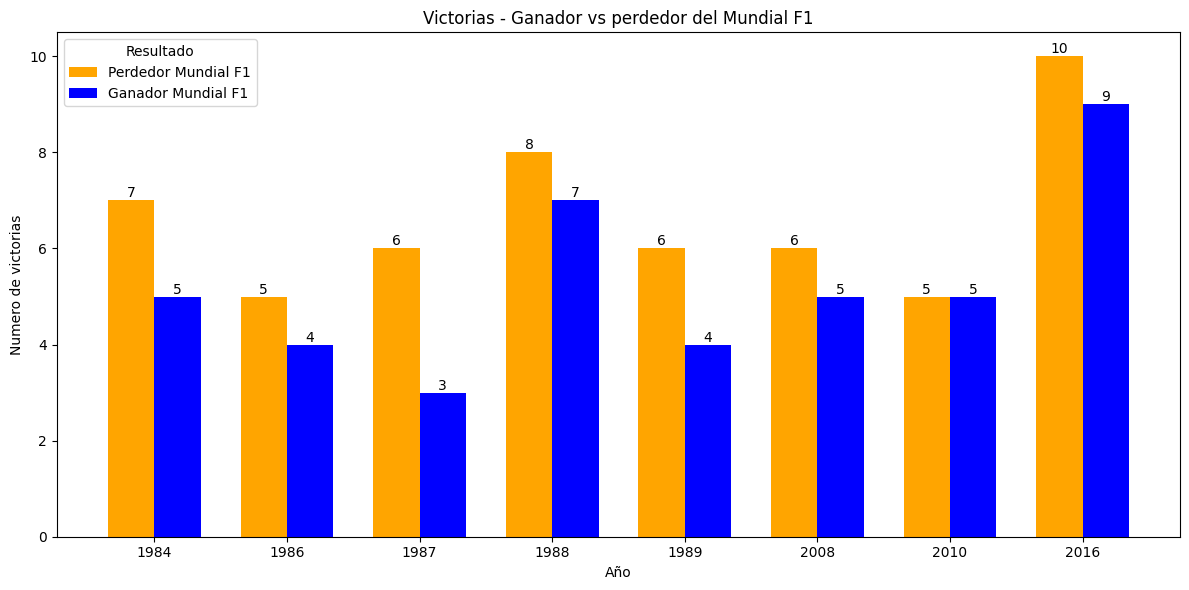

In [74]:
plt.figure(figsize=(12, 6))
bar_width = 0.35
x = np.arange(len(df_mala_suerte['year']))

bars1 = plt.bar(x - bar_width/2, df_mala_suerte['count_x'], width=bar_width, label='Perdedor Mundial F1', color='orange')
bars2 = plt.bar(x + bar_width/2, df_mala_suerte['count_y'], width=bar_width, label='Ganador Mundial F1', color='blue')

plt.xlabel('Año')
plt.ylabel('Numero de victorias')
plt.title('Victorias - Ganador vs perdedor del Mundial F1')
plt.xticks(x, df_mala_suerte['year'])  

plt.legend(title='Resultado')

for bar in bars1:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom') 

for bar in bars2:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, int(yval), ha='center', va='bottom')  # Para count_y

plt.savefig("./img/1_Mismo_driver/No_ganador_mas_carreras_1.png")   
plt.tight_layout()
plt.show()



# 2. Cálculo TOP 3 pilotos

## 2.1 Cálculo TOP 3 pilotos con mas victorias en cada temporada

In [75]:
df_victorias = df_F1[df_F1['positionOrder'] == 1]
df_victorias_count = df_victorias.groupby(['year', 'driverName']).size().reset_index(name='victories')
top_pilots_per_year = df_victorias_count.sort_values(['year', 'victories'], ascending=[True, False]) \
                                         .groupby('year') \
                                         .head(3)
top_pilots_per_year

,year,driverName,victories
0,1984,Alain Prost,7
4,1984,Niki Lauda,5
3,1984,Nelson Piquet,2
5,1985,Alain Prost,5
6,1985,Ayrton Senna,2
...,...,...,...
194,2022,Charles Leclerc,3
197,2022,Sergio Pérez,2
199,2023,Max Verstappen,19
200,2023,Sergio Pérez,2


In [76]:
top_pilots_per_year['position'] = top_pilots_per_year.groupby('year')['victories'].rank(method='first', ascending=False).astype(int)

top_pilots_per_year

,year,driverName,victories,position
0,1984,Alain Prost,7,1
4,1984,Niki Lauda,5,2
3,1984,Nelson Piquet,2,3
5,1985,Alain Prost,5,1
6,1985,Ayrton Senna,2,2
...,...,...,...,...
194,2022,Charles Leclerc,3,2
197,2022,Sergio Pérez,2,3
199,2023,Max Verstappen,19,1
200,2023,Sergio Pérez,2,2


### Gráfico diferencias entre las carreras ganadas entre los 3 pilotos que mas carreras ganaron

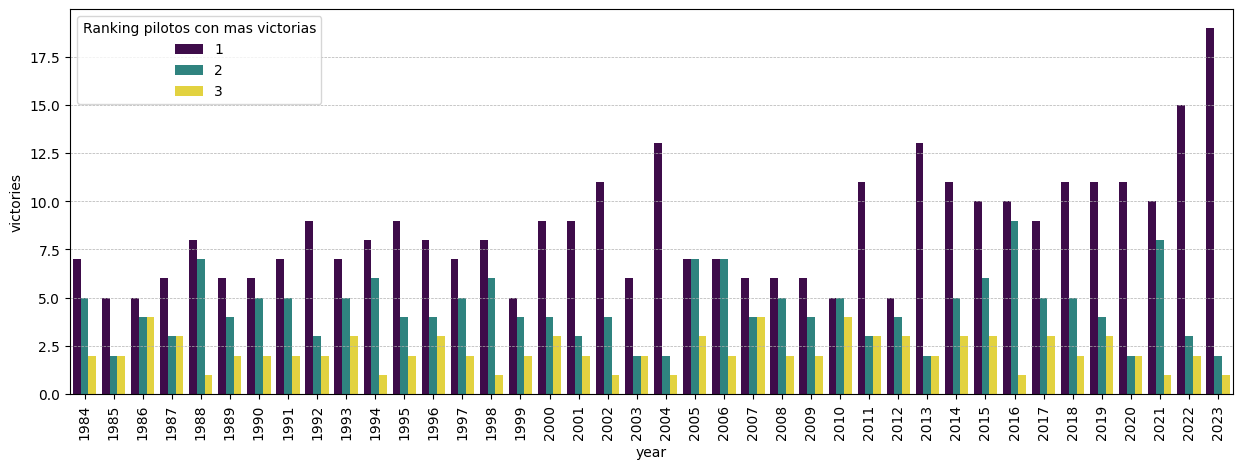

In [82]:
fig, axs = plt.subplots(nrows=1,ncols=1,figsize=(15,5))
sns.barplot(top_pilots_per_year, x="year", y="victories", hue="position", palette="viridis")
axs.tick_params(axis="x", labelrotation=90)
plt.legend(title="Ranking pilotos con mas victorias")
plt.grid(axis="y", linestyle = "dashed", linewidth = 0.5)

plt.savefig("./img/1_Mismo_driver/Top_3_1.png")   

## 2.2 Cálculo % de diferencia entre el piloto con mas victorias y el segundo piloto con mas victorias

In [78]:
top_pilots_per_year['position'] = top_pilots_per_year.groupby('year')['victories'].rank(method='first', ascending=False).astype(int)

piloto_1_victories = top_pilots_per_year[top_pilots_per_year['position'] == 1].groupby('year')['victories'].sum()
piloto_2_victories = top_pilots_per_year[top_pilots_per_year['position'] == 2].groupby('year')['victories'].sum()

victories_comparison = pd.DataFrame({
    'Year': piloto_1_victories.index,
    'Piloto 1': piloto_1_victories.values,
    'Piloto 2': piloto_2_victories.values
})

victories_comparison['Suma Total'] = victories_comparison['Piloto 1'] + victories_comparison['Piloto 2']
victories_comparison['Diferencia'] = victories_comparison['Piloto 1'] - victories_comparison['Piloto 2']
victories_comparison['Porcentaje (%)'] = round((victories_comparison['Diferencia'] / victories_comparison['Suma Total']) * 100,1)
victories_comparison['Porcentaje (%)'].fillna('N/A', inplace=True)

victories_comparison.head(3)

C:\Users\Luis\AppData\Local\Temp\ipykernel_30784\2469026294.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  victories_comparison['Porcentaje (%)'].fillna('N/A', inplace=True)


,Year,Piloto 1,Piloto 2,Suma Total,Diferencia,Porcentaje (%)
0,1984,7,5,12,2,16.7
1,1985,5,2,7,3,42.9
2,1986,5,4,9,1,11.1


### Gráfica diferencia porcentual entre el piloto con mas carreras ganadas y el segundo

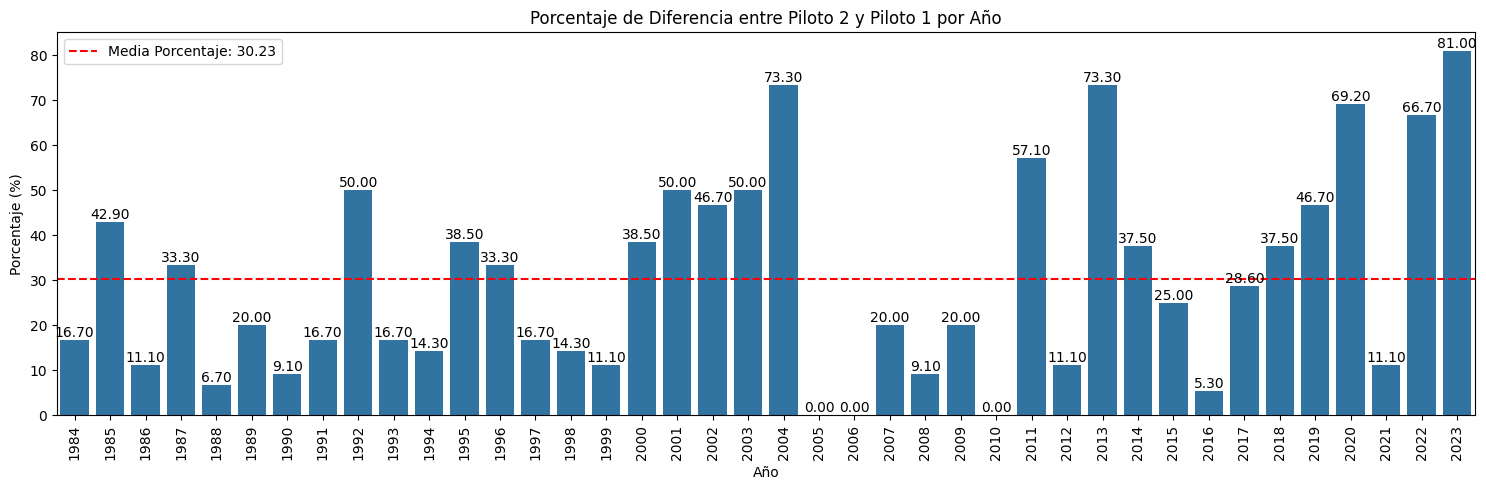

In [79]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15, 5))
sns.barplot(data=victories_comparison, x="Year", y="Porcentaje (%)", ax=axs)

mean_percentage = victories_comparison['Porcentaje (%)'].mean()

axs.axhline(mean_percentage, color='red', linestyle='--', label=f'Media Porcentaje: {mean_percentage:.2f}')

axs.set_title('Porcentaje de Diferencia entre Piloto 2 y Piloto 1 por Año')
axs.set_ylabel('Porcentaje (%)')
axs.set_xlabel('Año')

axs.tick_params(axis="x", labelrotation=90)


for p in axs.patches:
    axs.annotate(f'{p.get_height():.2f}', 
                 (p.get_x() + p.get_width() / 2., p.get_height()), 
                 ha='center', va='bottom')

axs.legend()

plt.savefig("./img/1_Mismo_driver/Top_3_media_incluida.png") 
plt.tight_layout()
plt.show()



## 1.4 Distribucion por años de numeros diferentes de pilotos ganadores y numero de carreras ganadas por cada uno de ellos

In [80]:
df_pos_1_all = df_pos_1.groupby(["year","driverName"],as_index=False)["positionOrder"].count()
df_wins = df_pos_1_all.groupby(['year', 'driverName'])['positionOrder'].sum().reset_index()
df_pivot = df_wins.pivot(index='year', columns='driverName', values='positionOrder').fillna(0)
df_pivot.head(3)

driverName,Alain Prost,Alessandro Nannini,Ayrton Senna,Carlos Sainz,Charles Leclerc,Damon Hill,Daniel Ricciardo,David Coulthard,Eddie Irvine,Elio de Angelis,Esteban Ocon,Felipe Massa,Fernando Alonso,George Russell,Gerhard Berger,Giancarlo Fisichella,Heikki Kovalainen,Heinz-Harald Frentzen,Jacques Villeneuve,Jarno Trulli,Jean Alesi,Jenson Button,Johnny Herbert,Juan Pablo Montoya,Keke Rosberg,Kimi Räikkönen,Lewis Hamilton,Mark Webber,Max Verstappen,Michael Schumacher,Michele Alboreto,Mika Häkkinen,Nelson Piquet,Nico Rosberg,Nigel Mansell,Niki Lauda,Olivier Panis,Pastor Maldonado,Pierre Gasly,Ralf Schumacher,Riccardo Patrese,Robert Kubica,Rubens Barrichello,Sebastian Vettel,Sergio Pérez,Thierry Boutsen,Valtteri Bottas
year,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
1984,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1985,5.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,0.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1986,4.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


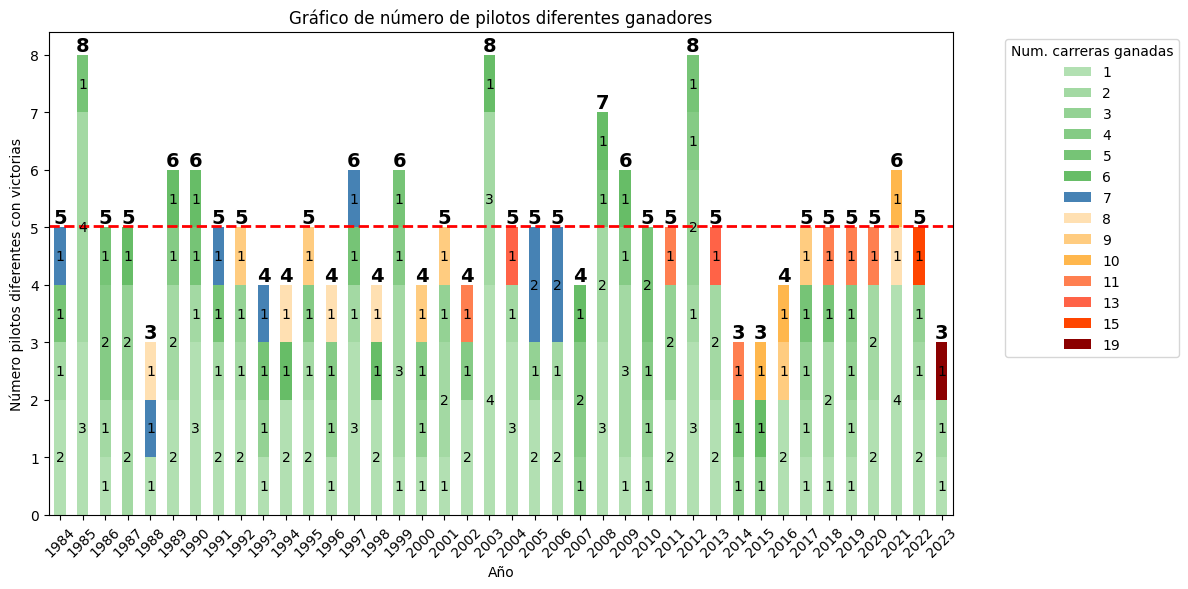

In [81]:
df_counts = df_pos_1_all.groupby(['year', 'positionOrder']).size().unstack(fill_value=0)


colors = [
    '#B2E0B2',  # Verde claro 1
    '#A3D9A3',  # Verde claro 2
    '#94D294',  # Verde claro 3
    '#85CB85',  # Verde claro 4
    '#76C476',  # Verde claro 5
    '#67BD67',   # Verde claro 6
    '#4682B4',  # Azul
    '#FFE0B2',  # Naranja Suave 3
    '#FFCC80',  # Naranja Suave 2
    '#FFB74D',   # Naranja Suave 1 
    '#FF7F50',  # Coral (rojizo)
    '#FF6347',  # Tomate (rojizo)
    '#FF4500',  # Naranja rojizo
    '#8B0000'   # Rojo oscuro (Dark Red)
]

ax = df_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)


plt.title('Gráfico de número de pilotos diferentes ganadores')
plt.xlabel('Año')
plt.ylabel('Número pilotos diferentes con victorias')
plt.xticks(rotation=45)


for i in range(len(df_counts)):
    total_height = df_counts.iloc[i].sum()  
    ax.annotate(f'{int(total_height)}',
                xy=(i, total_height), 
                ha='center', 
                va='bottom',
                fontsize=14,   
                fontweight='bold')  
    

mean_value = df_counts.sum(axis=1).mean()  
ax.axhline(mean_value, color='red', linestyle='--', linewidth=2)  


ax.annotate("",
            xy=(len(df_counts)-1, mean_value), 
            xytext=(len(df_counts)-1, mean_value + 1), 
            ha='center',
            fontsize=12,
            color='red',
            fontweight='bold')


for p in ax.patches:
    height = p.get_height()
    if height > 0:  
        ax.annotate(f'{int(height)}',
                    (p.get_x() + p.get_width() / 2., p.get_y() + height / 2.), 
                    ha='center', va='center')


plt.legend(title='Num. carreras ganadas', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.savefig("./img/1_Mismo_driver/All_drivers_wins_distribution.png") 
plt.tight_layout()
plt.show()

 